## 0. Data exploration

In [4]:
# Import necessary libraries for data exploration
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random

In [5]:
# Explore dataset containing segmentation masks
df_masks = pd.read_csv('train_ship_segmentations_v2.csv')
df_masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
# Add a column to indicate if an image has ships
df_masks['has_ship'] = df_masks['EncodedPixels'].notnull()

In [7]:
# Dimension of images
image = plt.imread(f"train_v2/{df_masks['ImageId'].iloc[0]}")
width = image.shape[0]
height = image.shape[1]
print(f"Width: {width}, Height: {height}")

Width: 768, Height: 768


In [8]:
# Count the number of images, the number with ships, and calculate the ratio
num_images_total = df_masks['ImageId'].nunique()
num_images_with_ships = df_masks[df_masks['EncodedPixels'].notna()]['ImageId'].nunique()
num_images_without_ships = num_images_total - num_images_with_ships
ratio_ship_no_ship = num_images_with_ships / num_images_without_ships if num_images_without_ships != 0 else float('inf')

print(f"Total number of images: {num_images_total}")
print(f"Number of images with ships: {num_images_with_ships}")
print(f"Number of images without ships: {num_images_without_ships}")
print(f"Ratio of images with ships to without ships: {ratio_ship_no_ship:.2f}")
df_masks.shape

Total number of images: 192556
Number of images with ships: 42556
Number of images without ships: 150000
Ratio of images with ships to without ships: 0.28


(231723, 3)

In [9]:
def rle_decode(mask_rle, shape=(width, height)):
    """
    Decodes a run-length encoded (RLE) mask string into a 2D binary mask array.

    Run-Length Encoding (RLE) is a compact representation of binary masks.
    The mask is represented as pairs of start and length values, indicating the
    consecutive pixels that should be set to 1 (foreground) in an otherwise zero
    (background) mask.
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

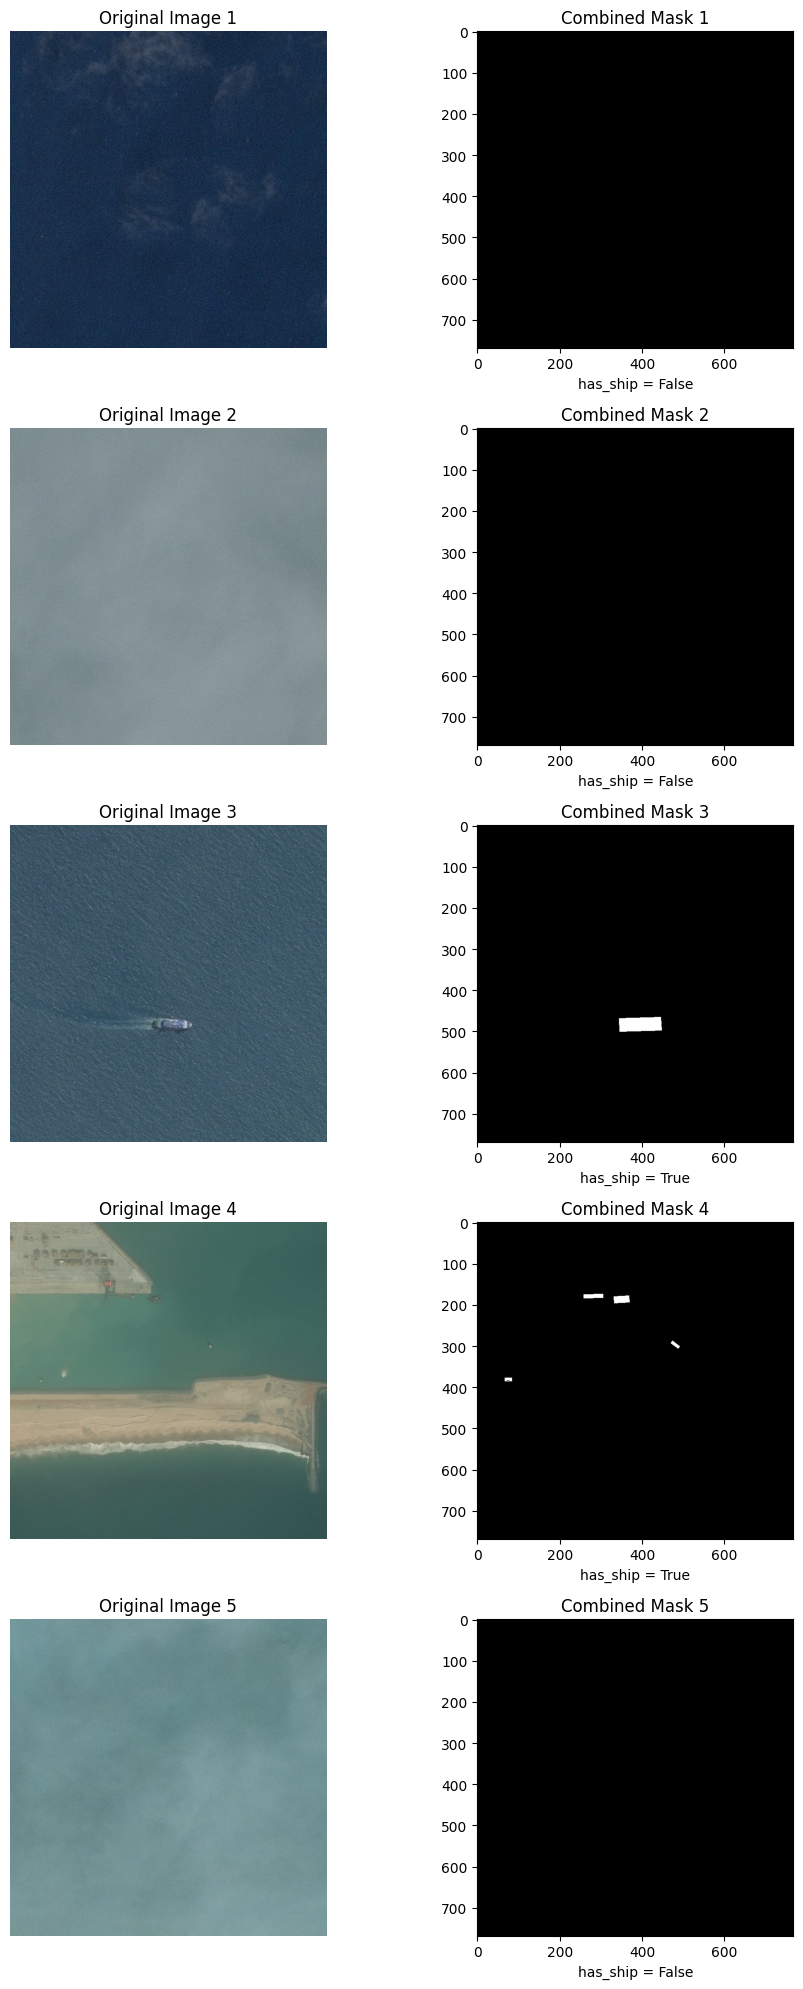

In [10]:
num_images = 5
plt.figure(figsize=(10, 20))

# Get unique image IDs to display
unique_image_ids = df_masks['ImageId'].unique()[:num_images]

for i, image_id in enumerate(unique_image_ids):
    # Select all Run-Length Encoding (RLE) masks for the current image
    image_rles = df_masks[df_masks['ImageId'] == image_id]['EncodedPixels'].values
    has_ship = df_masks[df_masks['ImageId'] == image_id]['has_ship'].values[0]  # Check if it has a ship

    # Load the original image from the training dataset (train_v2 folder)
    image_path = f"train_v2/{image_id}"
    image = plt.imread(image_path)  # Load the original image

    # Initialize an empty mask
    combined_mask = np.zeros((width, height), dtype=np.uint8)

    # Decode each RLE and combine the masks
    for rle in image_rles:
        if pd.notna(rle):  # If RLE is not NaN, decode it
            combined_mask |= rle_decode(rle, shape=(width, height))  # Combine masks using logical OR

    # Display the original image
    plt.subplot(num_images, 2, 2 * i + 1)  # Two columns: original image on the left
    plt.imshow(image)  # Display the original image
    plt.title(f"Original Image {i + 1}")  # Title for the original image
    plt.axis('off')  # Remove axis for a cleaner display

    # Display the combined mask
    plt.subplot(num_images, 2, 2 * i + 2)  # Two columns: mask on the right
    plt.imshow(combined_mask, cmap='gray')  # Show the mask in grayscale
    plt.title(f"Combined Mask {i + 1}")  # Title for each mask
    plt.xlabel(f"has_ship = {has_ship}")  # Add text below indicating if the image has a ship

plt.tight_layout()
plt.show()

## 1. Creating training and validation datasets

In [11]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, Subset
import torchvision.transforms.functional as TF

In [12]:
class ShipDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df  # DataFrame containing image IDs and encoded pixel masks
        self.img_dir = img_dir  # Directory where images are stored
        self.transforms = transforms  # Optional transformations to apply
        self.image_ids = df['ImageId'].unique()  # Get unique image IDs
        self.imageid_to_mask = self._generate_image_mask_map()  # Map image IDs to their masks

    def _generate_image_mask_map(self):
        imageid_to_mask = {}
        for img_id in self.image_ids:
            # Get all records (rows) for this image ID
            records = self.df[self.df['ImageId'] == img_id]
            # Get list of encoded pixel masks for this image
            masks = records['EncodedPixels'].tolist()
            # Map the image ID to its list of masks
            imageid_to_mask[img_id] = masks
        return imageid_to_mask

    def __len__(self):
        # Return the total number of images
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get the image ID at the given index
        img_id = self.image_ids[idx]
        # Construct the full image path
        img_path = os.path.join(self.img_dir, img_id)
        # Open the image and convert it to RGB
        image = Image.open(img_path).convert("RGB")

        # Get all masks associated with this image
        masks = self.imageid_to_mask[img_id]
        # Initialize an empty mask with the same size as the images
        mask = np.zeros((768, 768), dtype=np.uint8)
        for m in masks:
            if isinstance(m, str):
                # Decode the Run-Length Encoding (RLE) mask and add it to the mask
                mask += rle_decode(m)
        # Convert the mask to a PIL image
        mask = Image.fromarray(mask)

        if self.transforms:
            # Apply transformations to both image and mask
            image, mask = self.transforms(image, mask)

        # Return the image and its corresponding mask
        return image, mask

In [ ]:
def basic_transforms(image, mask):
    resize_size = (256, 256)
    image = image.resize(resize_size, resample=Image.BILINEAR)
    mask = mask.resize(resize_size, resample=Image.NEAREST)

    # Convert to tensors
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float()
    return image, mask

def augmentation_transforms(image, mask):
    resize_size = (256, 256)
    image = image.resize(resize_size, resample=Image.BILINEAR)
    mask = mask.resize(resize_size, resample=Image.NEAREST)

    image = TF.hflip(image)
    mask = TF.hflip(mask)

    # Convert to tensors
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float()
    return image, mask

In [ ]:
img_dir = 'train_v2/'
original_dataset = ShipDataset(df_masks, img_dir=img_dir, transforms=basic_transforms)
augmented_dataset = ShipDataset(df_masks, img_dir=img_dir, transforms=augmentation_transforms)

In [ ]:
from torch.utils.data import ConcatDataset

# Combine the original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

print(f"Total number of data points in the combined dataset: {len(combined_dataset)}")

In [ ]:
# Create a mapping from image_id to has_ship label
imageid_to_has_ship = df_masks.groupby('ImageId')['has_ship'].any().to_dict()

# Get lists of indices for images with and without ships
with_ship_indices = []
without_ship_indices = []

for idx, img_id in enumerate(combined_dataset.image_ids):
    if imageid_to_has_ship[img_id]:
        with_ship_indices.append(idx)
    else:
        without_ship_indices.append(idx)

In [ ]:
from sklearn.model_selection import train_test_split

# Split indices for images with ships
train_with_ship_indices, val_with_ship_indices = train_test_split(
    with_ship_indices,
    test_size=0.2,
    random_state=42
)

# Split indices for images without ships
train_without_ship_indices, val_without_ship_indices = train_test_split(
    without_ship_indices,
    test_size=0.2,
    random_state=42
)

# Combine train and validation indices
train_indices = train_with_ship_indices + train_without_ship_indices
val_indices = val_with_ship_indices + val_without_ship_indices

# Shuffle indices
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

In [ ]:
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

In [ ]:
num_train_images = len(train_dataset)
print(f"Number of training images: {num_train_images}")

num_val_images = len(val_dataset)
print(f"Number of validation images: {num_val_images}")

In [1]:
# Helper function to display a random sample from a dataset
def display_random_sample(dataset):
    # Get a random index
    random_idx = random.randint(0, len(dataset) - 1)

    # Retrieve the image and mask
    image, mask = dataset[random_idx]

    # Convert tensors to NumPy arrays
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()

    # Display
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_np)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask_np, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

In [2]:
display_random_sample(val_dataset)

NameError: name 'val_dataset' is not defined

<a target="_blank" href="https://colab.research.google.com/github/istex9/ctr-alt-segmentAnything/blob/main/airbus_ship_detection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>